# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Compute the $Q_0$

## Configuration

### Load libraries and setup

In [1]:
import os
import sys
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
try:
    BASEPATH = os.path.dirname(os.path.realpath(__file__))
    data_path = os.path.join(BASEPATH, "..", "..", "data")
except NameError:
    if os.path.exists("data"):
        BASEPATH = "."
        data_path = os.path.join(BASEPATH, "data")
    else:
        BASEPATH = os.getcwd()
        data_path = os.path.join(BASEPATH, "..", "..", "data")

In [3]:
sys.path.append(os.path.join(BASEPATH, "..", "..", "src"))
from mltier1 import Field, Q_0, parallel_process, describe

In [4]:
%load_ext autoreload

In [5]:
%autoreload

In [6]:
from IPython.display import clear_output

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

### Area limits

In [9]:
# Test samples
ra_down = 27.206
ra_up = 29.8
dec_down = 4.025
dec_up = 7.08

In [10]:
field = Field(4.025, 7.08, 27.206, 29.8)

In [11]:
field_op = Field(3.8, 7.3, 27.0, 30.0)

## Load data

In [12]:
combined_all = Table.read(os.path.join(data_path, "samples", "test_combined.fits"))

In [13]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
lofar_all = Table.read(os.path.join(data_path, "samples", "P005p28.fits"))

In [14]:
np.array(combined_all.colnames)

array(['RA', 'DEC', 'UID_L', 'UNWISE_OBJID', 'MAG_R', 'MAG_W1', 'MAG_W2'],
      dtype='<U12')

In [15]:
np.array(lofar_all.colnames)

array(['Source_id', 'Isl_id', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Total_flux',
       'E_Total_flux', 'Peak_flux', 'E_Peak_flux', 'RA_max', 'E_RA_max',
       'DEC_max', 'E_DEC_max', 'Maj', 'E_Maj', 'Min', 'E_Min', 'PA',
       'E_PA', 'Maj_img_plane', 'E_Maj_img_plane', 'Min_img_plane',
       'E_Min_img_plane', 'PA_img_plane', 'E_PA_img_plane', 'DC_Maj',
       'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'DC_PA', 'E_DC_PA',
       'DC_Maj_img_plane', 'E_DC_Maj_img_plane', 'DC_Min_img_plane',
       'E_DC_Min_img_plane', 'DC_PA_img_plane', 'E_DC_PA_img_plane',
       'Isl_Total_flux', 'E_Isl_Total_flux', 'Isl_rms', 'Isl_mean',
       'Resid_Isl_rms', 'Resid_Isl_mean', 'S_Code'], dtype='<U18')

### Filter catalogues

In [16]:
lofar = field.filter_catalogue(
    lofar_all[(lofar_all["Maj"] < 30.0)], colnames=("RA", "DEC")
)

In [17]:
combined = field.filter_catalogue(combined_all, colnames=("RA", "DEC"))

In [18]:
print(len(lofar_all), len(lofar))

5471 3452


In [19]:
print(len(combined_all), len(combined))

3449056 547371


### Sky coordinates

In [20]:
coords_combined = SkyCoord(
    combined["RA"], combined["DEC"], unit=(u.deg, u.deg), frame="icrs"
)

In [21]:
coords_lofar = SkyCoord(lofar["RA"], lofar["DEC"], unit=(u.deg, u.deg), frame="icrs")

### Summary of galaxy types in the combined catalogue

In [22]:
combined_legacy = (
    ~np.isnan(combined["MAG_R"])
    & ~np.isnan(combined["MAG_W1"])
    & ~np.isnan(combined["MAG_W2"])
)
np.sum(combined_legacy)  # Matches

485701

In [23]:
combined_matched = ~np.isnan(combined["MAG_R"]) & (combined["UNWISE_OBJID"] != "N/A")
np.sum(combined_matched)

153210

In [24]:
combined_legacy_only = ~np.isnan(combined["MAG_R"]) & (
    combined["UNWISE_OBJID"] == "N/A"
)
np.sum(combined_legacy_only)  # Only Legacy

332491

In [25]:
print(np.sum(combined_legacy))
print(np.sum(combined_matched) + np.sum(combined_legacy_only))

485701
485701


In [26]:
combined_wise = np.isnan(combined["MAG_R"]) & (~np.isnan(combined["MAG_W1"]))
np.sum(combined_wise)  # Only WISE

54618

In [27]:
combined_wise2 = np.isnan(combined["MAG_R"]) & np.isnan(combined["MAG_W1"])
np.sum(combined_wise2)  # Only WISE2

7052

In [28]:
print(len(combined))
print(np.sum(combined_legacy) + np.sum(combined_wise) + np.sum(combined_wise2))

547371
547371


## $Q_0$ dependence on the radius

We will iterate 10 times for each radius.

In [29]:
n_iter = 10

In [30]:
rads = list(range(1,26))

### r-band

In [31]:
q_0_comp_r = Q_0(coords_lofar, coords_combined[combined_legacy], field)

In [32]:
q_0_rad_r = []
q_0_rad_r_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        try:
            out = q_0_comp_r(radius=radius)
        except ZeroDivisionError:
            continue
        else:
            q_0_rad_aux.append(out)
    q_0_rad_r.append(np.mean(q_0_rad_aux))
    q_0_rad_r_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.39575 +/- 0.00103 [0.39391 0.39712]
 2 0.56465 +/- 0.00234 [0.56115 0.56924]
 3 0.60450 +/- 0.00319 [0.59716 0.60919]
 4 0.62994 +/- 0.00263 [0.62563 0.63404]
 5 0.64551 +/- 0.00517 [0.64055 0.65380]
 6 0.65473 +/- 0.00642 [0.64507 0.66578]
 7 0.66857 +/- 0.00682 [0.65872 0.68294]
 8 0.66965 +/- 0.00553 [0.66039 0.67881]
 9 0.66963 +/- 0.00796 [0.65470 0.68041]
10 0.65939 +/- 0.00978 [0.64274 0.67428]
11 0.64541 +/- 0.02020 [0.61823 0.68687]
12 0.65078 +/- 0.01627 [0.62807 0.67976]
13 0.66757 +/- 0.01726 [0.64021 0.69369]
14 0.65381 +/- 0.03266 [0.62097 0.71856]
15 0.67520 +/- 0.01874 [0.65432 0.70526]
16 0.67339 +/- 0.02493 [0.62745 0.70312]
17 0.58694 +/- 0.04423 [0.51724 0.66667]
18 0.49688 +/- 0.06712 [0.37500 0.56522]
19 0.36053 +/- 0.15774 [0.00000 0.56250]
20 0.24923 +/- 0.45733 [-1.00000 0.69231]
21 -0.08000 +/- 0.69217 [-2.00000 0.40000]
22 -0.80000 +/- 0.81240 [-2.00000 0.00000]
23 -0.28000 +/- 0.62738 [-1.00000 0.60000]
24 1.00000 +/- 0.00000 [1.00000 1.00000]
25 1.0000

(0, 1)

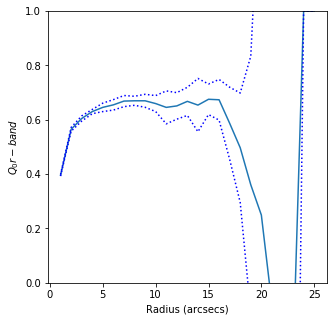

In [33]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_r)
plt.plot(rads, np.array(q_0_rad_r) + 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_r) - 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 r-band$")
plt.ylim([0, 1])

### W1-band

In [34]:
q_0_comp_w1 = Q_0(coords_lofar, coords_combined[combined_wise], field)

In [35]:
q_0_rad_w1 = []
q_0_rad_w1_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    q_0_rad_w1_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.04430 +/- 0.00065 [0.04330 0.04524]
 2 0.09085 +/- 0.00148 [0.08867 0.09450]
 3 0.12454 +/- 0.00182 [0.12130 0.12698]
 4 0.15627 +/- 0.00246 [0.15306 0.16062]
 5 0.18343 +/- 0.00259 [0.17838 0.18756]
 6 0.19461 +/- 0.00308 [0.19033 0.20080]
 7 0.20788 +/- 0.00405 [0.20115 0.21424]
 8 0.21572 +/- 0.00446 [0.20909 0.22215]
 9 0.22194 +/- 0.00677 [0.20973 0.23389]
10 0.22826 +/- 0.00587 [0.21948 0.23855]
11 0.24001 +/- 0.00747 [0.22756 0.25460]
12 0.24585 +/- 0.00506 [0.23630 0.25251]
13 0.24169 +/- 0.00649 [0.23010 0.25213]
14 0.24524 +/- 0.00881 [0.23141 0.26253]
15 0.24186 +/- 0.00688 [0.23084 0.25372]
16 0.24352 +/- 0.00686 [0.23586 0.26002]
17 0.24883 +/- 0.00839 [0.23652 0.26128]
18 0.25078 +/- 0.00773 [0.23792 0.26109]
19 0.24889 +/- 0.01105 [0.22930 0.27024]
20 0.23958 +/- 0.00661 [0.22410 0.24732]
21 0.24151 +/- 0.01031 [0.22001 0.25253]
22 0.23743 +/- 0.00977 [0.22898 0.26283]
23 0.22456 +/- 0.01404 [0.20825 0.25899]
24 0.21648 +/- 0.01398 [0.19805 0.24665]
25 0.21509 +/- 0

(0, 0.4)

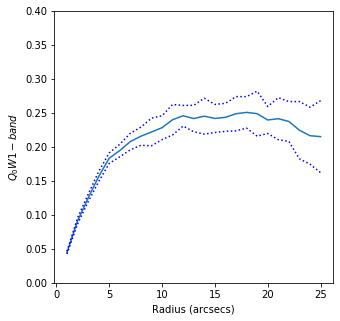

In [36]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_w1)
plt.plot(rads, np.array(q_0_rad_w1) + 3 * np.array(q_0_rad_w1_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_w1) - 3 * np.array(q_0_rad_w1_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W1-band$")
plt.ylim([0, 0.4])

### W2-band

In [37]:
q_0_comp_w2 = Q_0(coords_lofar, coords_combined[combined_wise2], field)

In [38]:
q_0_rad_w2 = []
q_0_rad_w2_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w2(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w2.append(np.mean(q_0_rad_aux))
    q_0_rad_w2_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.00246 +/- 0.00019 [0.00203 0.00261]
 2 0.00487 +/- 0.00071 [0.00349 0.00580]
 3 0.01211 +/- 0.00067 [0.01076 0.01305]
 4 0.01739 +/- 0.00075 [0.01659 0.01888]
 5 0.02422 +/- 0.00173 [0.01991 0.02647]
 6 0.02392 +/- 0.00179 [0.02114 0.02714]
 7 0.02914 +/- 0.00150 [0.02732 0.03159]
 8 0.03202 +/- 0.00162 [0.02919 0.03375]
 9 0.03631 +/- 0.00167 [0.03236 0.03779]
10 0.03872 +/- 0.00287 [0.03454 0.04366]
11 0.03814 +/- 0.00263 [0.03472 0.04359]
12 0.03887 +/- 0.00202 [0.03583 0.04218]
13 0.04147 +/- 0.00233 [0.03697 0.04450]
14 0.04503 +/- 0.00394 [0.03883 0.05273]
15 0.04757 +/- 0.00138 [0.04533 0.04941]
16 0.05148 +/- 0.00412 [0.04522 0.05920]
17 0.05261 +/- 0.00282 [0.04766 0.05764]
18 0.05231 +/- 0.00440 [0.04256 0.05888]
19 0.05258 +/- 0.00502 [0.04413 0.06170]
20 0.04860 +/- 0.00792 [0.03518 0.06360]
21 0.04593 +/- 0.00454 [0.03611 0.05184]
22 0.04654 +/- 0.00411 [0.04014 0.05282]
23 0.04835 +/- 0.00575 [0.03776 0.05682]
24 0.04992 +/- 0.00726 [0.04005 0.05982]
25 0.04979 +/- 0

(0, 0.08)

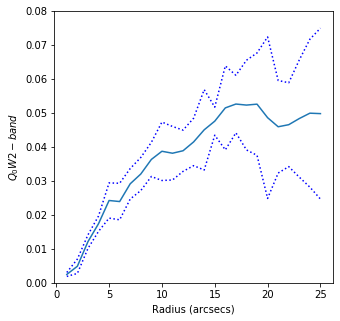

In [39]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_w2)
plt.plot(rads, np.array(q_0_rad_w2) + 3 * np.array(q_0_rad_w2_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_w2) - 3 * np.array(q_0_rad_w2_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W2-band$")
plt.ylim([0, 0.08])